Importing pandas, matplotlib, and numpy as well as executing the matplotlib magic command to begin the exercise.

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Reading the data and then taking a peek at what the first few rows look like. 

In [344]:
dfCS = pd.read_csv('ConstructionTimeSeriesDatav2.csv')
dfCS.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


Dropping the other construction spend columns as they will be distracting when we're focusing on the private spend for this analysis.

In [326]:
dfCS.drop('Total Construction',axis=1, inplace=True)
dfCS.drop('Public Construction',axis=1, inplace=True)
dfCS.head()

,Month,Month-Year,Private Construction
0,1,Jan-02,45273
1,2,Feb-02,44475
2,3,Mar-02,49396
3,4,Apr-02,53283
4,5,May-02,55009


Quickly graphing the data to get a better understanding of what decomposing method should be used.

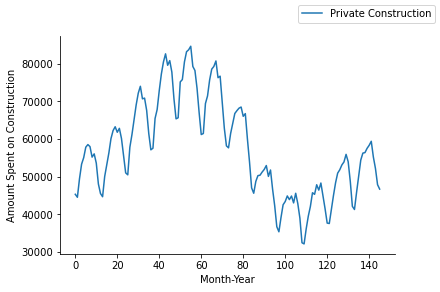

In [327]:
fig,ax = plt.subplots()
ax.plot(dfCS['Private Construction'],label='Private Construction')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Amount Spent on Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

It appears as if the more general model for decomposing the data will be more helpful when analyzing the construction spending data. We'll begin by computing a moving average utilizng the squared error to guide the analysis. it seems as if a window of 12 months will provide the best fit while maintaining a low squared error. 

The graph displays a fairly smooth curve that follows the private construction spending fairly well.

Average Squared Error per Month:  72830695.4473684
            Month Month-Year  Private Construction        MovAvg         sqErr
2003-02-28     14     Feb-03                 44620  56659.333333  1.449455e+08
2003-03-31     15     Mar-03                 49996  56604.916667  4.367778e+07
2003-04-30     16     Apr-03                 53195  57065.000000  1.497690e+07
2003-05-31     17     May-03                 56286  57381.583333  1.200303e+06
2003-06-30     18     Jun-03                 60076  57631.833333  5.973951e+06
...           ...        ...                   ...           ...           ...
2013-10-31    142     Oct-13                 59370  56189.000000  1.011876e+07
2013-11-30    143     Nov-13                 55191  56647.000000  2.119936e+06
2013-12-31    144     Dec-13                 52132  56588.916667  1.986411e+07
2014-01-31    145     Jan-14                 47827  56438.083333  7.415076e+07
2014-02-28    146     Feb-14                 46647  56362.000000  9.438122e+07



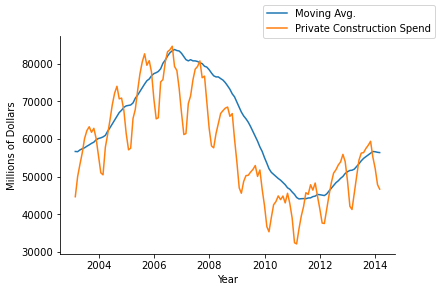

In [328]:
def sqErr(row):
    return (row[1] - row[2])**2
   
dfCS['MovAvg'] = np.NaN
dfCS['sqErr'] = np.NaN
dfCS.index = pd.date_range(freq = 'm', start = pd.Timestamp(year = 2002, month = 1, day = 31), periods = len(dfCS['Private Construction']))

window = 12
for i in range(window+1,len(dfCS)):
    dfCS.loc[dfCS.index[i],'MovAvg'] = sum(dfCS.iloc[range(i-window-1,i)]['Private Construction'])/float(window)
dfCS['sqErr'] = (dfCS['Private Construction'] - dfCS['MovAvg'])**2
dfCS.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(dfCS['MovAvg'], label='Moving Avg.')
ax.plot(dfCS['Private Construction'], label='Private Construction Spend')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Squared Error per Month: ',sum(dfCS['sqErr'])/len(dfCS))
print(dfCS)

Creating R1 and R1Error columns where R1error is a percentage of the total Private spend for the month

In [329]:
dfCS['R1'] = dfCS['Private Construction'] - dfCS['MovAvg']
dfCS['R1Error'] = abs((dfCS['Private Construction'] - dfCS['R1'])/dfCS['Private Construction'])
dfCS.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format    
})

,Month,Month-Year,Private Construction,MovAvg,sqErr,R1,R1Error
2003-02-28 00:00:00,14,Feb-03,44620,56659.3,"144,945,547.1",-12039.333333,1.269819
2003-03-31 00:00:00,15,Mar-03,49996,56604.9,"43,677,779.5",-6608.916667,1.132189
2003-04-30 00:00:00,16,Apr-03,53195,57065.0,"14,976,900.0",-3870.000000,1.072751
2003-05-31 00:00:00,17,May-03,56286,57381.6,"1,200,302.8",-1095.583333,1.019465
2003-06-30 00:00:00,18,Jun-03,60076,57631.8,"5,973,950.7",2444.166667,0.959315
2003-07-31 00:00:00,19,Jul-03,62216,58054.1,"17,321,550.3",4161.916667,0.933105
2003-08-31 00:00:00,20,Aug-03,63234,58422.0,"23,155,344.0",4812.000000,0.923902
2003-09-30 00:00:00,21,Sep-03,61767,58817.0,"8,702,500.0",2950.000000,0.952240
2003-10-31 00:00:00,22,Oct-03,62813,59134.8,"13,528,910.0",3678.166667,0.941443
2003-11-30 00:00:00,23,Nov-03,60115,59772.8,"117,078.0",342.166667,0.994308


time to take a look at the remaining pattern to be decomposed. while it does potentially have a longer cyclic nature, it has become increasingly clear the construction is a season business where spending in the summer exceeds spending in the winter.

Average Residual:  -4806.822055137844


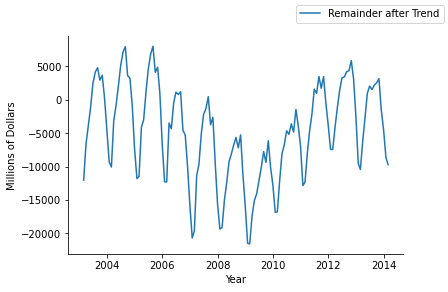

In [331]:
fig,ax = plt.subplots()
ax.plot(dfCS['R1'],label='Remainder after Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Residual: ', sum(dfCS['R1'])/len(dfCS))


To properly handle the seasonal nature of the remainder, I used the visualization techniques explained during the discussion of the linear regression with a seasonal component to confirm my hypothesis of a seasonal pattern to the remainder.


            Month Month-Year  Private Construction        MovAvg  \
2003-02-28     14     Feb-03                 44620  56659.333333   
2003-03-31     15     Mar-03                 49996  56604.916667   
2003-04-30     16     Apr-03                 53195  57065.000000   
2003-05-31     17     May-03                 56286  57381.583333   
2003-06-30     18     Jun-03                 60076  57631.833333   
...           ...        ...                   ...           ...   
2013-10-31    142     Oct-13                 59370  56189.000000   
2013-11-30    143     Nov-13                 55191  56647.000000   
2013-12-31    144     Dec-13                 52132  56588.916667   
2014-01-31    145     Jan-14                 47827  56438.083333   
2014-02-28    146     Feb-14                 46647  56362.000000   

                   sqErr            R1   R1Error        S  
2003-02-28  1.449455e+08 -12039.333333  1.269819      NaN  
2003-03-31  4.367778e+07  -6608.916667  1.132189      NaN  
200

C:\Users\garvermb2\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0.5, 0, 'Year')

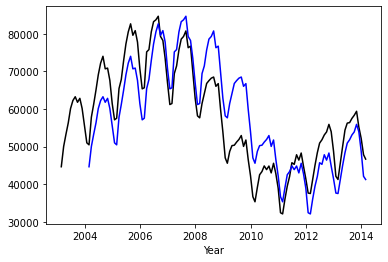

In [332]:
# Create column with lag of 12
lag = 12
dfCS['S'] = np.NaN
for i in range(len(dfCS['S']))[lag:]:
    dfCS['S'].iloc[i] = dfCS['Private Construction'].iloc[i-12]
print(dfCS)

# Compute autocorrelations
for i in range(int(len(dfCS.index)/2)):
    print('autocorrelation, lag =',i,':',dfCS.R1.autocorr(lag = i))
    
fig,ax = plt.subplots()
ax.plot(dfCS['Private Construction'],c='k')
ax.plot(dfCS.S,c='b')
ax.set_xlabel('Year')

I then graphed each year, to see if the shape was similar, and it did appear to be fairly consistent, regardless of year.

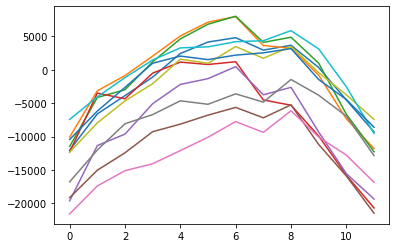

In [333]:
dfYR = pd.DataFrame()
cycleLen = 12
for i in range(int(len(dfCS.index)/cycleLen)):
    newData = pd.DataFrame({i:dfCS['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfYR = pd.concat([dfYR,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfYR)

I then created an avg and overalyed it on the rest of the years to again confirm the it represented the seasonality properly.

               0             1             2             3             4  \
0  -12039.333333 -10080.166667 -11491.416667 -12321.083333 -19646.166667   
1   -6608.916667  -3147.833333  -4143.750000  -3490.750000 -11355.000000   
2   -3870.000000   -864.833333  -2987.750000  -4343.083333  -9640.083333   
3   -1095.583333   2053.416667   1209.166667   -498.000000  -5077.250000   
4    2444.166667   5079.416667   4631.416667   1155.083333  -2192.333333   
5    4161.916667   7147.666667   6834.166667    797.916667  -1323.833333   
6    4812.000000   7970.833333   8029.750000   1210.083333    470.333333   
7    2950.000000   3649.750000   4113.166667  -4518.333333  -3741.750000   
8    3678.166667   3224.750000   4883.916667  -5307.250000  -2627.166667   
9     342.166667   -803.666667    991.416667  -9929.833333  -9330.750000   
10  -4529.833333  -7348.333333  -6667.083333 -15805.583333 -15565.916667   
11  -9308.166667 -11802.583333 -12279.000000 -20716.416667 -19370.833333   

           

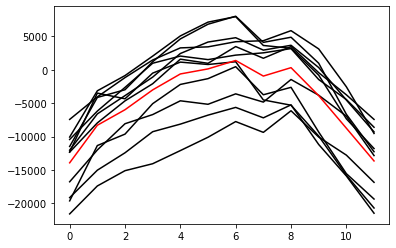

In [335]:
avg = []
for i in range(len(dfYR.index)):
    avg.append(dfYR.iloc[i].mean())

dfYR = pd.concat([dfYR,pd.DataFrame({'avg':avg})], axis=1)
print(dfYR)

fig,ax = plt.subplots()
c = 180
for col in dfYR.columns.values:
    if col == 'avg':
        ax.plot(dfYR[col], c = 'r')
    else:
        ax.plot(dfYR[col], c = 'k')

I dropped the seasonality column and will recreate it using the process explained in the second lecture to be uniform with the other calculations

In [336]:
dfCS.drop('S',axis=1, inplace=True)

As you can see, by recreating the seasonal pattern, a large portion of R1 will be explained by S which is the annual spending pattern of the private construction firms.

0 2003-02-28   -12039.333333
2004-02-29   -10080.166667
2005-02-28   -11491.416667
2006-02-28   -12321.083333
2007-02-28   -19646.166667
2008-02-29   -19160.666667
2009-02-28   -21602.000000
2010-02-28   -16784.833333
2011-02-28   -12345.416667
2012-02-29    -7437.000000
2013-02-28   -10442.666667
Freq: 12M, Name: R1, dtype: float64
1 2003-03-31    -6608.916667
2004-03-31    -3147.833333
2005-03-31    -4143.750000
2006-03-31    -3490.750000
2007-03-31   -11355.000000
2008-03-31   -15049.000000
2009-03-31   -17411.833333
2010-03-31   -12016.583333
2011-03-31    -7958.666667
2012-03-31    -4057.750000
2013-03-31    -6188.750000
Freq: 12M, Name: R1, dtype: float64
2 2003-04-30    -3870.000000
2004-04-30     -864.833333
2005-04-30    -2987.750000
2006-04-30    -4343.083333
2007-04-30    -9640.083333
2008-04-30   -12440.416667
2009-04-30   -15121.083333
2010-04-30    -8082.416667
2011-04-30    -4656.583333
2012-04-30    -1167.333333
2013-04-30    -2635.833333
Freq: 12M, Name: R1, dtype: flo

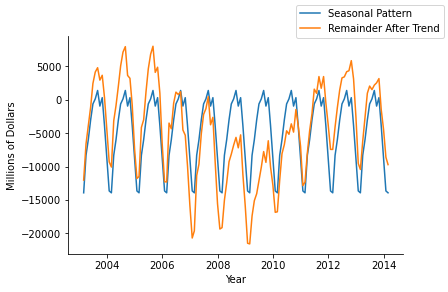

In [337]:
cycleLen = 12   
avg = []            # a list to store the average demand for each period of the cycle
numCycles = int(len(dfCS)/cycleLen + 0.5)
for j in range(cycleLen):
    if j + (numCycles-1) * cycleLen < len(dfCS):
        d = dfCS.iloc[range(j,j + (numCycles-1) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
    else:
        d = dfCS.iloc[range(j,j + (numCycles-2) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
dfCS['S'] = np.NaN
for i in range(len(dfCS)):
    dfCS.loc[dfCS.index[i], 'S'] = avg[i % cycleLen]

fig,ax = plt.subplots()
ax.plot(dfCS['S'],label='Seasonal Pattern')
ax.plot(dfCS['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

I then created R2 which is a represnetation of the additional error that cannot be explained by the initial attempt as well as the additional of the seasonal factor to the model. The average error is 0.077 or 7.7% which is fairly low, meaning the model + seasonality can account for much of the changes in spending over time.

            Month Month-Year  Private Construction        MovAvg  \
2003-02-28     14     Feb-03                 44620  56659.333333   
2003-03-31     15     Mar-03                 49996  56604.916667   
2003-04-30     16     Apr-03                 53195  57065.000000   
2003-05-31     17     May-03                 56286  57381.583333   
2003-06-30     18     Jun-03                 60076  57631.833333   
...           ...        ...                   ...           ...   
2013-10-31    142     Oct-13                 59370  56189.000000   
2013-11-30    143     Nov-13                 55191  56647.000000   
2013-12-31    144     Dec-13                 52132  56588.916667   
2014-01-31    145     Jan-14                 47827  56438.083333   
2014-02-28    146     Feb-14                 46647  56362.000000   

                   sqErr            R1   R1Error             S           R2  \
2003-02-28  1.449455e+08 -12039.333333  1.269819 -13940.977273  1901.643939   
2003-03-31  4.367778e+07 

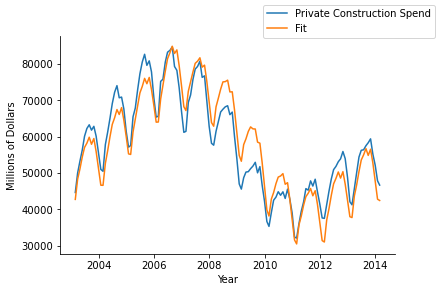

In [338]:
dfCS['R2'] = dfCS['R1'] - dfCS['S']
dfCS['R2Error'] = abs(dfCS['R2']/dfCS['Private Construction'])
dfCS['fit'] = dfCS['MovAvg'] + dfCS['S']
print(dfCS)
fig,ax = plt.subplots()
ax.plot(dfCS['Private Construction'],label='Private Construction Spend')
ax.plot(dfCS['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Error: ', sum(dfCS['R2Error']/len(dfCS)))

Taking a closer look at the R2 error, it appears as if the most dramatic changes to the value are during the global financial crisis which began in the second half of 2007 and spanned well into 2009. the impact can be seen here with the R2 going from a positive value to a negative value fairly quickly. 

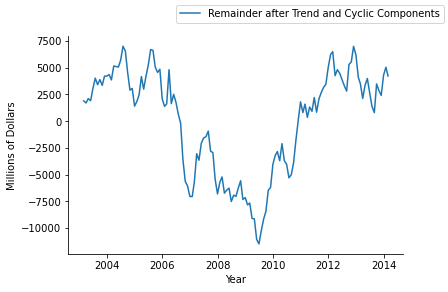

In [339]:
fig,ax = plt.subplots()
ax.plot(dfCS['R2'], label='Remainder after Trend and Cyclic Components')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()



Finally, the fit can be seen to follow the spend quite closely regardless of the change in overall spend during the global financial crisis. 

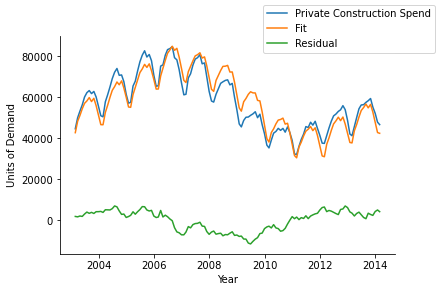

In [313]:
fig,ax = plt.subplots()
ax.plot(dfCS['Private Construction'],label='Private Construction Spend')
ax.plot(dfCS['fit'],label='Fit')
ax.plot(dfCS['R2'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

I will repeat all steps for public spend below and make comments only where the data behaved differntly. 

In [367]:
dfCS = pd.read_csv('ConstructionTimeSeriesDatav2.csv')
dfCS.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


In [368]:
dfCS.drop('Total Construction',axis=1, inplace=True)
dfCS.drop('Private Construction',axis=1, inplace=True)
dfCS.head()

,Month,Month-Year,Public Construction
0,1,Jan-02,14243
1,2,Feb-02,14113
2,3,Mar-02,14386
3,4,Apr-02,16221
4,5,May-02,18375


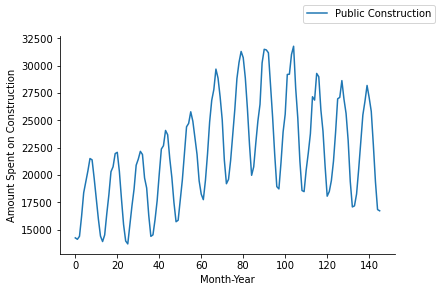

In [346]:
fig,ax = plt.subplots()
ax.plot(dfCS['Public Construction'],label='Public Construction')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Amount Spent on Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

upon initial inspection, the data seems to behave in a similar fashion, the changes are not as dramatic, which is to be expected since public budgets are a established and set many years in advance. 

Average Squared Error per Month:  15405036.556808686
            Month Month-Year  Public Construction        MovAvg         sqErr
2003-02-28     14     Feb-03                13906  18986.833333  2.581487e+07
2003-03-31     15     Mar-03                14510  18958.750000  1.979138e+07
2003-04-30     16     Apr-03                16444  18991.833333  6.491455e+06
2003-05-31     17     May-03                18187  19163.333333  9.532268e+05
2003-06-30     18     Jun-03                20301  19327.166667  9.483514e+05
...           ...        ...                  ...           ...           ...
2013-10-31    142     Oct-13                25823  24884.583333  8.806258e+05
2013-11-30    143     Nov-13                22741  24791.666667  4.205234e+06
2013-12-31    144     Dec-13                19369  24550.750000  2.685053e+07
2014-01-31    145     Jan-14                16834  24235.833333  5.478714e+07
2014-02-28    146     Feb-14                16721  24022.333333  5.330947e+07

[133 rows 

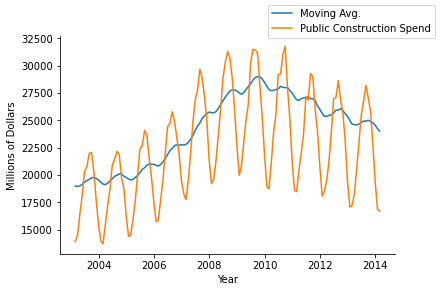

In [369]:
def sqErr(row):
    return (row[1] - row[2])**2
   
dfCS['MovAvg'] = np.NaN
dfCS['sqErr'] = np.NaN
dfCS.index = pd.date_range(freq = 'm', start = pd.Timestamp(year = 2002, month = 1, day = 31), periods = len(dfCS['Public Construction']))

window = 12
for i in range(window+1,len(dfCS)):
    dfCS.loc[dfCS.index[i],'MovAvg'] = sum(dfCS.iloc[range(i-window-1,i)]['Public Construction'])/float(window)
dfCS['sqErr'] = (dfCS['Public Construction'] - dfCS['MovAvg'])**2
dfCS.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(dfCS['MovAvg'], label='Moving Avg.')
ax.plot(dfCS['Public Construction'], label='Public Construction Spend')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Squared Error per Month: ',sum(dfCS['sqErr'])/len(dfCS))
print(dfCS)

In [371]:
dfCS['R1'] = dfCS['Public Construction'] - dfCS['MovAvg']
dfCS['R1Error'] = abs((dfCS['Public Construction'] - dfCS['R1'])/dfCS['Public Construction'])
dfCS.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format    
})

,Month,Month-Year,Public Construction,MovAvg,sqErr,R1,R1Error
2003-02-28 00:00:00,14,Feb-03,13906,18986.8,"25,814,867.4",-5080.833333,1.365370
2003-03-31 00:00:00,15,Mar-03,14510,18958.8,"19,791,376.6",-4448.750000,1.306599
2003-04-30 00:00:00,16,Apr-03,16444,18991.8,"6,491,454.7",-2547.833333,1.154940
2003-05-31 00:00:00,17,May-03,18187,19163.3,"953,226.8",-976.333333,1.053683
2003-06-30 00:00:00,18,Jun-03,20301,19327.2,"948,351.4",973.833333,0.952030
2003-07-31 00:00:00,19,Jul-03,20755,19487.7,"1,606,133.8",1267.333333,0.938938
2003-08-31 00:00:00,20,Aug-03,21957,19602.2,"5,545,240.0",2354.833333,0.892753
2003-09-30 00:00:00,21,Sep-03,22075,19734.5,"5,477,940.2",2340.500000,0.893975
2003-10-31 00:00:00,22,Oct-03,20321,19781.8,"290,700.7",539.166667,0.973468
2003-11-30 00:00:00,23,Nov-03,17801,19693.2,"3,580,294.7",-1892.166667,1.106296


Interestingly, the public construction remainder seems to be even more seasonal based than the private sector.

Average Residual:  -1650.7117794486214


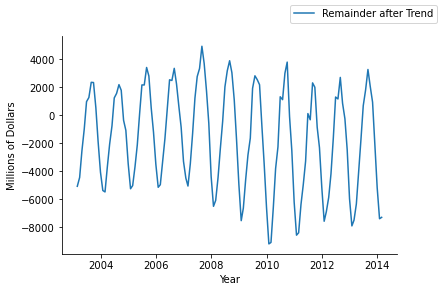

In [372]:
fig,ax = plt.subplots()
ax.plot(dfCS['R1'],label='Remainder after Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Residual: ', sum(dfCS['R1'])/len(dfCS))

            Month Month-Year  Public Construction        MovAvg         sqErr  \
2003-02-28     14     Feb-03                13906  18986.833333  2.581487e+07   
2003-03-31     15     Mar-03                14510  18958.750000  1.979138e+07   
2003-04-30     16     Apr-03                16444  18991.833333  6.491455e+06   
2003-05-31     17     May-03                18187  19163.333333  9.532268e+05   
2003-06-30     18     Jun-03                20301  19327.166667  9.483514e+05   
...           ...        ...                  ...           ...           ...   
2013-10-31    142     Oct-13                25823  24884.583333  8.806258e+05   
2013-11-30    143     Nov-13                22741  24791.666667  4.205234e+06   
2013-12-31    144     Dec-13                19369  24550.750000  2.685053e+07   
2014-01-31    145     Jan-14                16834  24235.833333  5.478714e+07   
2014-02-28    146     Feb-14                16721  24022.333333  5.330947e+07   

                     R1   R

C:\Users\garvermb2\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0.5, 0, 'Year')

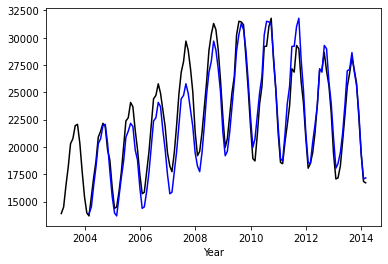

In [373]:
# Create column with lag of 12
lag = 12
dfCS['S'] = np.NaN
for i in range(len(dfCS['S']))[lag:]:
    dfCS['S'].iloc[i] = dfCS['Public Construction'].iloc[i-12]
print(dfCS)

# Compute autocorrelations
for i in range(int(len(dfCS.index)/2)):
    print('autocorrelation, lag =',i,':',dfCS.R1.autocorr(lag = i))
    
fig,ax = plt.subplots()
ax.plot(dfCS['Public Construction'],c='k')
ax.plot(dfCS.S,c='b')
ax.set_xlabel('Year')

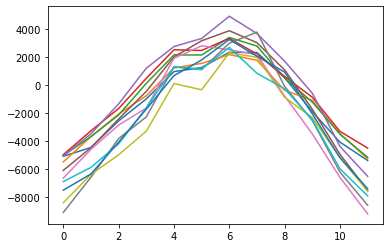

In [374]:
dfYR = pd.DataFrame()
cycleLen = 12
for i in range(int(len(dfCS.index)/cycleLen)):
    newData = pd.DataFrame({i:dfCS['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfYR = pd.concat([dfYR,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfYR)

As seen in the seasonal graphs, the public construction spend seasonality is even more similar, with an autocorrelation of 96%, making even more of the R1 explainable by seasonality.

              0            1            2            3            4  \
0  -5080.833333 -5484.833333 -5030.000000 -4966.250000 -5062.666667   
1  -4448.750000 -3671.250000 -3673.500000 -3254.333333 -3468.083333   
2  -2547.833333 -2065.333333 -2123.416667 -1666.916667 -1332.916667   
3   -976.333333  -755.583333   133.166667   494.083333  1219.916667   
4    973.833333  1239.666667  2167.833333  2535.500000  2765.833333   
5   1267.333333  1565.166667  2166.333333  2488.000000  3346.333333   
6   2354.833333  2189.916667  3416.500000  3354.333333  4935.250000   
7   2340.500000  1784.500000  2804.000000  2233.500000  3699.083333   
8    539.166667  -358.750000   511.250000   624.083333  1722.916667   
9  -1892.166667 -1080.000000 -1203.000000  -856.833333  -569.833333   
10 -4070.000000 -3468.000000 -3503.083333 -3300.750000 -4376.250000   
11 -5381.666667 -5257.500000 -5152.250000 -4493.833333 -6512.500000   

              5            6            7            8            9  \
0  -6

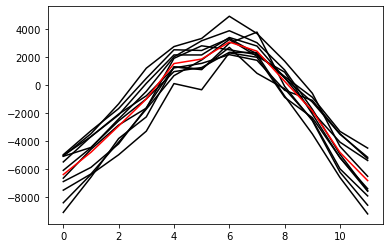

In [375]:
avg = []
for i in range(len(dfYR.index)):
    avg.append(dfYR.iloc[i].mean())

dfYR = pd.concat([dfYR,pd.DataFrame({'avg':avg})], axis=1)
print(dfYR)

fig,ax = plt.subplots()
c = 180
for col in dfYR.columns.values:
    if col == 'avg':
        ax.plot(dfYR[col], c = 'r')
    else:
        ax.plot(dfYR[col], c = 'k')

In [376]:
dfCS.drop('S',axis=1, inplace=True)

Again, displayed below is the large amount of seasonality exhibited by the public data set

0 2003-02-28   -5080.833333
2004-02-29   -5484.833333
2005-02-28   -5030.000000
2006-02-28   -4966.250000
2007-02-28   -5062.666667
2008-02-29   -6087.416667
2009-02-28   -6644.416667
2010-02-28   -9095.250000
2011-02-28   -8403.833333
2012-02-29   -6889.166667
2013-02-28   -7503.750000
Freq: 12M, Name: R1, dtype: float64
1 2003-03-31   -4448.750000
2004-03-31   -3671.250000
2005-03-31   -3673.500000
2006-03-31   -3254.333333
2007-03-31   -3468.083333
2008-03-31   -4466.500000
2009-03-31   -4585.500000
2010-03-31   -6577.333333
2011-03-31   -6379.416667
2012-03-31   -5873.250000
2013-03-31   -6343.750000
Freq: 12M, Name: R1, dtype: float64
2 2003-04-30   -2547.833333
2004-04-30   -2065.333333
2005-04-30   -2123.416667
2006-04-30   -1666.916667
2007-04-30   -1332.916667
2008-04-30   -2410.166667
2009-04-30   -2846.333333
2010-04-30   -3811.833333
2011-04-30   -4972.166667
2012-04-30   -4189.916667
2013-04-30   -4068.916667
Freq: 12M, Name: R1, dtype: float64
3 2003-05-31    -976.333333


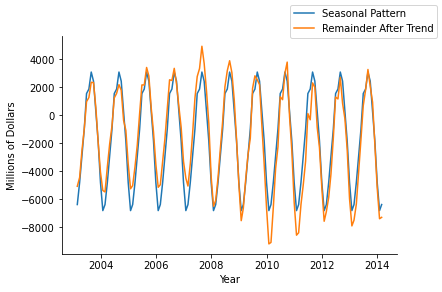

In [378]:
cycleLen = 12   
avg = []            # a list to store the average demand for each period of the cycle
numCycles = int(len(dfCS)/cycleLen + 0.5)
for j in range(cycleLen):
    if j + (numCycles-1) * cycleLen < len(dfCS):
        d = dfCS.iloc[range(j,j + (numCycles-1) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
    else:
        d = dfCS.iloc[range(j,j + (numCycles-2) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
dfCS['S'] = np.NaN
for i in range(len(dfCS)):
    dfCS.loc[dfCS.index[i], 'S'] = avg[i % cycleLen]

fig,ax = plt.subplots()
ax.plot(dfCS['S'],label='Seasonal Pattern')
ax.plot(dfCS['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The average error is 0.042 or 4.2% which is fairly low, meaning the model + seasonality can account for much of the changes in spending over time. Even moresore for the public data vs the private data.

            Month Month-Year  Public Construction        MovAvg         sqErr  \
2003-02-28     14     Feb-03                13906  18986.833333  2.581487e+07   
2003-03-31     15     Mar-03                14510  18958.750000  1.979138e+07   
2003-04-30     16     Apr-03                16444  18991.833333  6.491455e+06   
2003-05-31     17     May-03                18187  19163.333333  9.532268e+05   
2003-06-30     18     Jun-03                20301  19327.166667  9.483514e+05   
...           ...        ...                  ...           ...           ...   
2013-10-31    142     Oct-13                25823  24884.583333  8.806258e+05   
2013-11-30    143     Nov-13                22741  24791.666667  4.205234e+06   
2013-12-31    144     Dec-13                19369  24550.750000  2.685053e+07   
2014-01-31    145     Jan-14                16834  24235.833333  5.478714e+07   
2014-02-28    146     Feb-14                16721  24022.333333  5.330947e+07   

                     R1   R

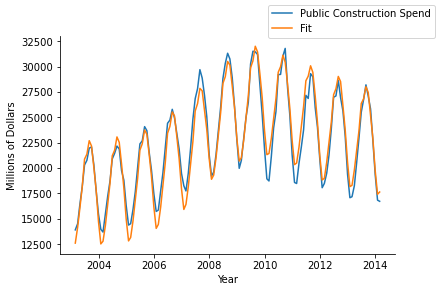

In [380]:
dfCS['R2'] = dfCS['R1'] - dfCS['S']
dfCS['R2Error'] = abs(dfCS['R2']/dfCS['Public Construction'])
dfCS['fit'] = dfCS['MovAvg'] + dfCS['S']
print(dfCS)
fig,ax = plt.subplots()
ax.plot(dfCS['Public Construction'],label='Public Construction Spend')
ax.plot(dfCS['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Error: ', sum(dfCS['R2Error']/len(dfCS)))

The remainder does change slightly duing and after the global financial crisis. it would be interesting to compare the two models side by side to gain a better understanding of the differences.

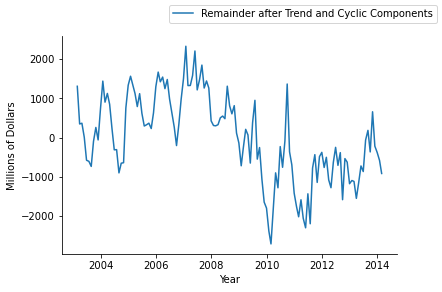

In [381]:
fig,ax = plt.subplots()
ax.plot(dfCS['R2'], label='Remainder after Trend and Cyclic Components')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()



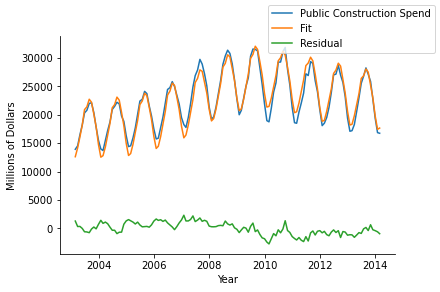

In [384]:
fig,ax = plt.subplots()
ax.plot(dfCS['Public Construction'],label='Public Construction Spend')
ax.plot(dfCS['fit'],label='Fit')
ax.plot(dfCS['R2'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Millions of Dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()